# Laboratory practice № 4 (astatisms)

Done by Vladislav Diuzhev (isu: 336225, group: R33353)

Variant: 16

## Preparation

In [1]:
import matplotlib.pyplot as plt
import control as ctrl
import sympy
import numpy as np

In [2]:
dt = 0.001

## Task 1 (Stabilization with ideal differentiator)

In [3]:
a_1 = sympy.Symbol("a_1")
a_0 = sympy.Symbol("a_0")
sympy.solve([-1 + 2 + a_1,-1 * 2 -a_0],a_1,a_0)

{a_0: -2, a_1: -1}

In [4]:
a_1 = sympy.Symbol("a_1")
a_0 = sympy.Symbol("a_0")
sympy.solve([-1  - 3 + a_1,-1 * (-3) -a_0],a_1,a_0)

{a_0: 3, a_1: 4}

In [5]:
k_0 = -5
k_1 = -5

In [6]:
tf_sys_1 = ctrl.tf([1],[1,-1,-2])
tf_sys_1 

TransferFunction(array([1]), array([ 1, -1, -2]))

In [7]:
ss_sys_1, _ = ctrl.canonical_form(ctrl.tf2ss(tf_sys_1), form="reachable")

In [8]:
modeling_time_1 = 10 # sec
time_1 = np.linspace(0,modeling_time_1,int(modeling_time_1/dt))
init_state_1 = [1, 2]

In [9]:
ss_sys_1

StateSpace(array([[1., 2.],
       [1., 0.]]), array([[1.],
       [0.]]), array([[0., 1.]]), array([[0.]]))

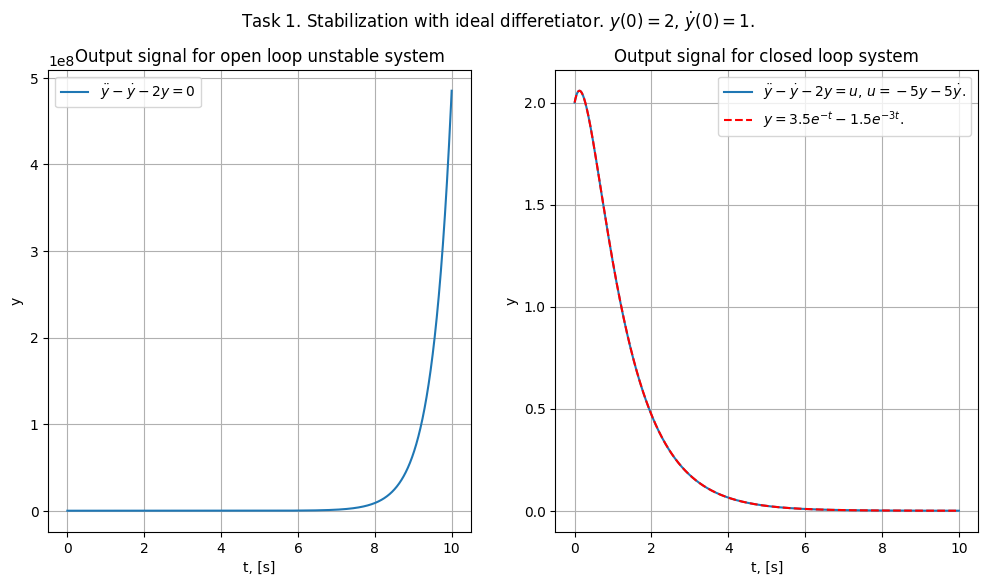

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
y_1_open = ctrl.initial_response(ss_sys_1,time_1,init_state_1).outputs
ax[0].plot(time_1,y_1_open,label="$\ddot y - \dot y - 2y=0$")

sys_state = init_state_1.copy()
y_1_closed = [sys_state[1]] * 2
for t_i in range(len(time_1)-1):
    u = k_0 * (y_1_closed[-1]) + k_1 * (y_1_closed[-1] - y_1_closed[-2])/dt
    res = ctrl.forced_response(ss_sys_1,time_1[t_i:t_i+2],u,sys_state)
    sys_state = res.states[:,-1].flatten().copy()
    y_1_closed.append(res.outputs[-1]) #+ (np.random.normal(0,0.01) if t_i % 10 == 0 else 0))
y_1_closed = y_1_closed[1:]
ax[1].plot(time_1,y_1_closed,label="$\ddot y - \dot y - 2y=u$, $u=-5y -5\dot y$.")
ax[1].plot(time_1, 3.5 * np.exp(-time_1) - 1.5 * np.exp(-3*time_1),"r--",label="$y=3.5 e^{-t} - 1.5 e^{-3t}$.")

fig.suptitle(f"Task 1. Stabilization with ideal differetiator. $y(0) = 2$, $\dot y(0)=1$.")
ax[0].set_ylabel("y")
ax[0].set_xlabel("t, [s]")
ax[0].grid(True)
ax[0].set_title(f"Output signal for open loop unstable system")
ax[0].legend()

ax[1].set_ylabel("y")
ax[1].set_xlabel("t, [s]")
ax[1].grid(True)
ax[1].set_title(f"Output signal for closed loop system")
ax[1].legend()

## Task 2 (Stabilization with real differentiator)

In [11]:
s, T = sympy.symbols("s T")

In [12]:
W = 1/(s**2-s -2) * (-5 - 5*s/(T*s+1))
W_f = W/(1-W)
W_f.simplify()

5*(-T*s - s - 1)/(5*T*s + 5*s - (T*s + 1)*(-s**2 + s + 2) + 5)

In [13]:
num, den = sympy.fraction(W_f.simplify())
den.expand(),"====", num.expand()

(T*s**3 - T*s**2 + 3*T*s + s**2 + 4*s + 3, '====', -5*T*s - 5*s - 5)

In [35]:
T_vals = [0.5, 0.1, 0.01]

In [36]:
num_coeffs = []
denom_coeffs = []
for T_val in T_vals:
    num_coeffs.append(list(map(float, sympy.Poly((num.expand()/T).subs(T,T_val),s).all_coeffs())))
    denom_coeffs.append(list(map(float, sympy.Poly((den.expand()/T).subs(T,T_val),s).all_coeffs())))

In [37]:
full_tfs_2  = [] 
for i in range(len(T_vals)):
    full_tfs_2.append(ctrl.tf(num_coeffs[i],denom_coeffs[i]))

In [38]:
def set_y_initials(ss, init):
    x_1, x_2, x_3 = sympy.symbols("x_1 x_2 x_3")
    sol = sympy.solve([
        ss.C[0][1]*x_2 + ss.C[0][2]*x_3 - init[0],
        ss.C[0][1]*x_1 + ss.C[0][2]*x_2 - init[1],
        ss.C[0][1]*(ss.A[0][0]*x_1+ss.A[0][1]*x_2+ss.A[0][2]*x_3) + ss.C[0][2]*x_1 - init[2]
    ])
    return list(map(float,[sol[x_1],sol[x_2],sol[x_3]]))

In [39]:
ss_sys = []
for i in range(len(T_vals)):
    ss_sys.append(ctrl.canonical_form(ctrl.tf2ss(full_tfs_2[i]),"reachable")[0])

In [40]:
modeling_time_2 = 10 # sec
time_2 = np.linspace(0,modeling_time_2,int(modeling_time_2/dt))
init_states_2 = []
for i in range(len(T_vals)):
    init_states_2.append(set_y_initials(ss_sys[i],[2,1,0]))

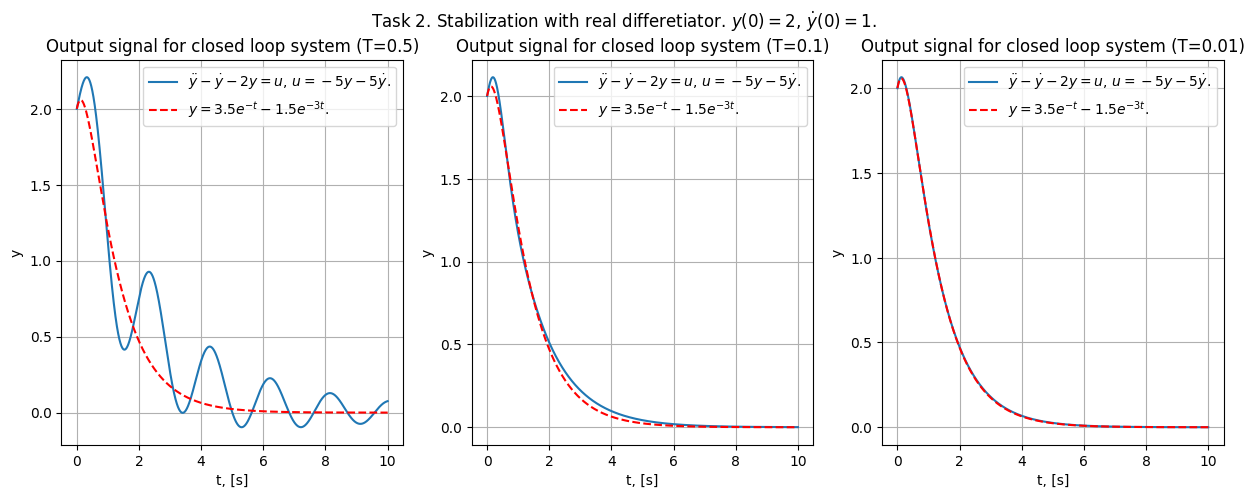

In [45]:
y_2_closed = []
y_2_closed.append(ctrl.initial_response(ss_sys[0],time_2,init_states_2[0]).outputs) 
y_2_closed.append(ctrl.initial_response(ss_sys[1],time_2,init_states_2[1]).outputs) 
y_2_closed.append(ctrl.initial_response(ss_sys[2],time_2,init_states_2[2]).outputs)  

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Task 2. Stabilization with real differetiator. $y(0) = 2$, $\dot y(0)=1$.")
for i in range(len(T_vals)):
    ax[i].plot(time_2,y_2_closed[i],label="$\ddot y - \dot y - 2y=u$, $u=-5y -5\dot y$.")
    ax[i].plot(time_2, 3.5 * np.exp(-time_2) - 1.5 * np.exp(-3*time_2),"r--",label="$y=3.5 e^{-t} - 1.5 e^{-3t}$.")
    ax[i].grid(True)
    ax[i].set_ylabel("y")
    ax[i].set_xlabel("t, [s]")
    ax[i].grid(True)
    ax[i].set_title(f"Output signal for closed loop system (T={T_vals[i]})")
    ax[i].legend()


## Task 3 (Noise)

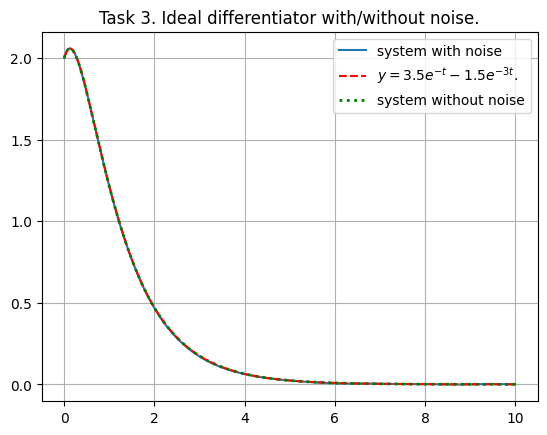

In [77]:
sys_state = init_state_1.copy()
y_1_closed_noise = [sys_state[1]] * 2
for t_i in range(len(time_1)-1):
    u = k_0 * (y_1_closed_noise[-1]) + k_1 * (y_1_closed_noise[-1] - y_1_closed_noise[-2])/dt + (np.random.normal(0,1) if t_i % 10 == 0 else 0)
    res = ctrl.forced_response(ss_sys_1,time_1[t_i:t_i+2],u,sys_state)
    sys_state = res.states[:,-1].flatten().copy()
    y_1_closed_noise.append(res.outputs[-1]) # + (np.random.normal(0,0.01) if t_i % 10 == 0 else 0)
y_1_closed_noise = y_1_closed_noise[1:]
plt.plot(time_1,y_1_closed_noise,label="system with noise")
plt.plot(time_1, 3.5 * np.exp(-time_1) - 1.5 * np.exp(-3*time_1),"r--",label="$y=3.5 e^{-t} - 1.5 e^{-3t}$.")
plt.plot(time_1,y_1_closed,"g:",linewidth=2,label="system without noise")
plt.grid(True)
plt.title("Task 3. Ideal differentiator with/without noise.")
plt.legend()

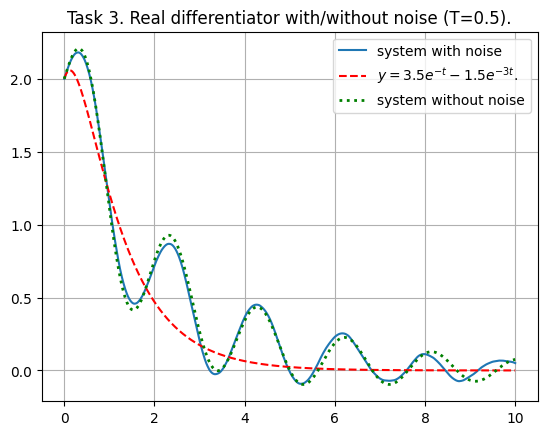

In [79]:
noise = np.zeros_like(time_2)
for i in range(len(time_2)// 10):
    noise[10*i] = np.random.normal(0,1)
plt.plot(time_2,ctrl.forced_response(ss_sys[0],time_2,noise,init_states_2[0]).outputs,label="system with noise")
plt.plot(time_2, 3.5 * np.exp(-time_2) - 1.5 * np.exp(-3*time_2),"r--",label="$y=3.5 e^{-t} - 1.5 e^{-3t}$.")
plt.plot(time_2,y_2_closed[0],"g:",linewidth=2,label="system without noise")
plt.grid(True)
plt.title("Task 3. Real differentiator with/without noise (T=0.5).")
plt.legend()

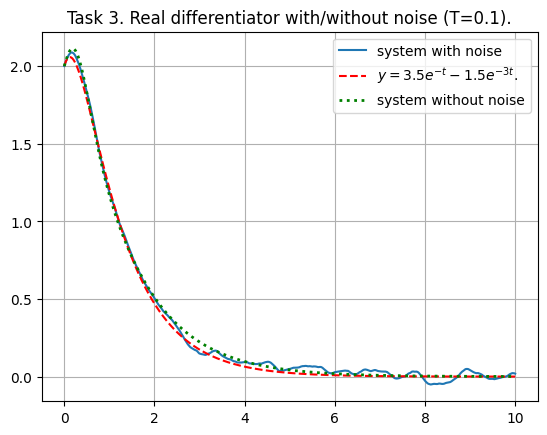

In [80]:
plt.plot(time_2,ctrl.forced_response(ss_sys[1],time_2,noise,init_states_2[1]).outputs,label="system with noise")
plt.plot(time_2, 3.5 * np.exp(-time_2) - 1.5 * np.exp(-3*time_2),"r--",label="$y=3.5 e^{-t} - 1.5 e^{-3t}$.")
plt.plot(time_2,y_2_closed[1],"g:",linewidth=2,label="system without noise")
plt.grid(True)
plt.title("Task 3. Real differentiator with/without noise (T=0.1).")
plt.legend()

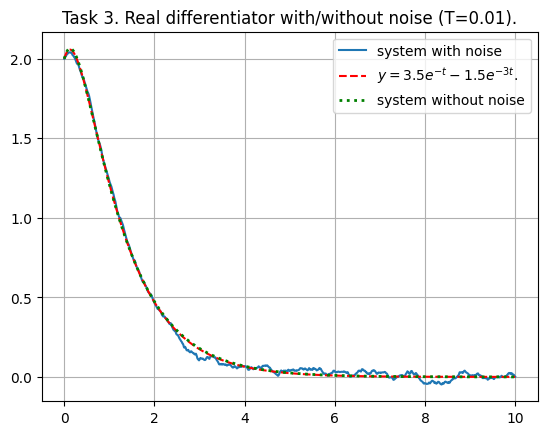

In [81]:
plt.plot(time_2,ctrl.forced_response(ss_sys[2],time_2,noise,init_states_2[2]).outputs,label="system with noise")
plt.plot(time_2, 3.5 * np.exp(-time_2) - 1.5 * np.exp(-3*time_2),"r--",label="$y=3.5 e^{-t} - 1.5 e^{-3t}$.")
plt.plot(time_2,y_2_closed[2],"g:",linewidth=2,label="system without noise")
plt.grid(True)
plt.title("Task 3. Real differentiator with/without noise (T=0.01).")
plt.legend()

## Task 4 (0 astatism)

In [83]:
time_4 = time_2.copy()

In [84]:
W_4 = (s + 1) / (s**2 + 5*s + 6)
W_4

(s + 1)/(s**2 + 5*s + 6)

In [85]:
k_0, k_1 = sympy.symbols("k_0 k_1")

In [86]:
W_reg_4 = k_0 

In [87]:
W_f = W_4 * W_reg_4/(1+ W_reg_4*W_4)
W_f.simplify()

k_0*(s + 1)/(k_0*(s + 1) + s**2 + 5*s + 6)

In [88]:
num, den = sympy.fraction(W_f.simplify())
den.expand(),"====", num.expand()

(k_0*s + k_0 + s**2 + 5*s + 6, '====', k_0*s + k_0)

In [112]:
k_val = 24

In [113]:
num_k = list(map(float, sympy.Poly((num.expand()).subs(k_0,k_val),s).all_coeffs()))
denom_k = list(map(float, sympy.Poly((den.expand()).subs(k_0,k_val),s).all_coeffs()))

In [114]:
tf_4 = ctrl.tf(num_k,denom_k)
tf_4

TransferFunction(array([24., 24.]), array([ 1., 29., 30.]))

0.39999733014602223


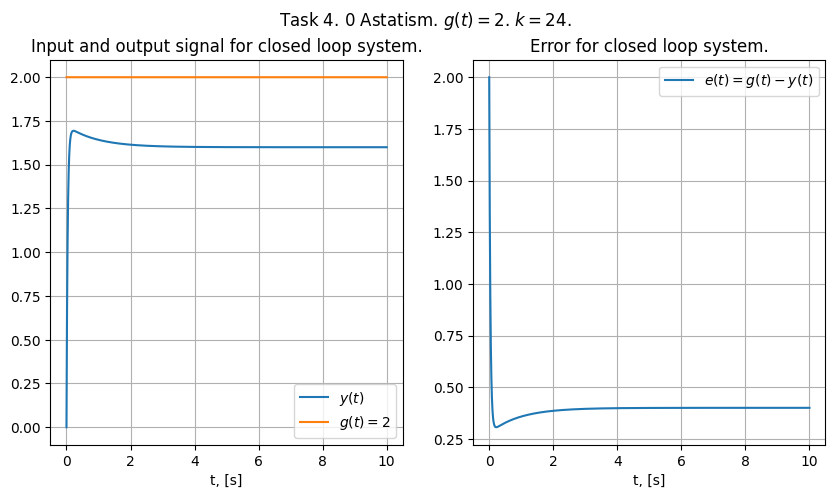

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"Task 4. 0 Astatism. $g(t)=2$. $k={k_val}$.")
ax[0].plot(time_4,ctrl.forced_response(tf_4,time_4,2).outputs,label="$y(t)$")
ax[0].plot(time_4, np.ones_like(time_4)*2,label="$g(t)=2$")
ax[0].set_xlabel("t, [s]")
ax[0].grid(True)
ax[0].set_title(f"Input and output signal for closed loop system.")
ax[0].legend()

ax[1].plot(time_4,np.ones_like(time_4)*2-ctrl.forced_response(tf_4,time_4,2).outputs,label="$e(t)=g(t)-y(t)$")
ax[1].set_xlabel("t, [s]")
ax[1].grid(True)
ax[1].set_title(f"Error for closed loop system.")
ax[1].legend()
print(2-ctrl.forced_response(tf_4,time_4,2).outputs[-1])

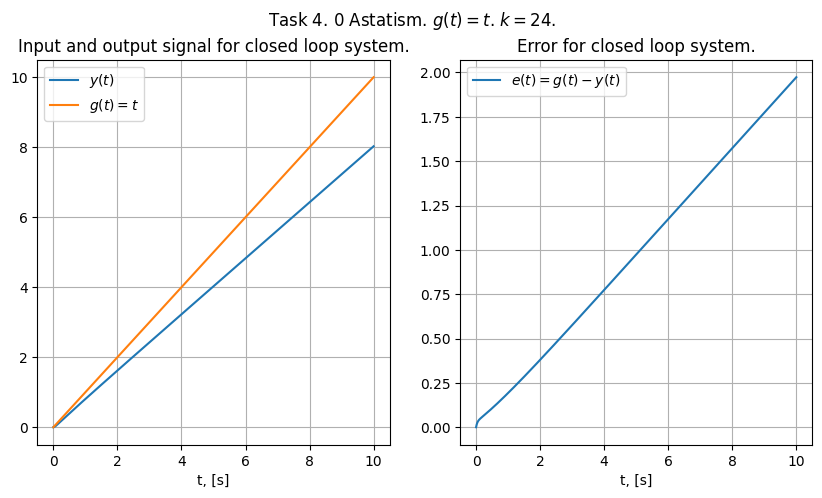

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"Task 4. 0 Astatism. $g(t)=t$. $k={k_val}$.")
ax[0].plot(time_4,ctrl.forced_response(tf_4,time_4,time_4).outputs,label="$y(t)$")
ax[0].plot(time_4, time_4,label="$g(t)=t$")
ax[0].set_xlabel("t, [s]")
ax[0].grid(True)
ax[0].set_title(f"Input and output signal for closed loop system.")
ax[0].legend()

ax[1].plot(time_4,time_4-ctrl.forced_response(tf_4,time_4,time_4).outputs,label="$e(t)=g(t)-y(t)$")
ax[1].set_xlabel("t, [s]")
ax[1].grid(True)
ax[1].set_title(f"Error for closed loop system.")
ax[1].legend()

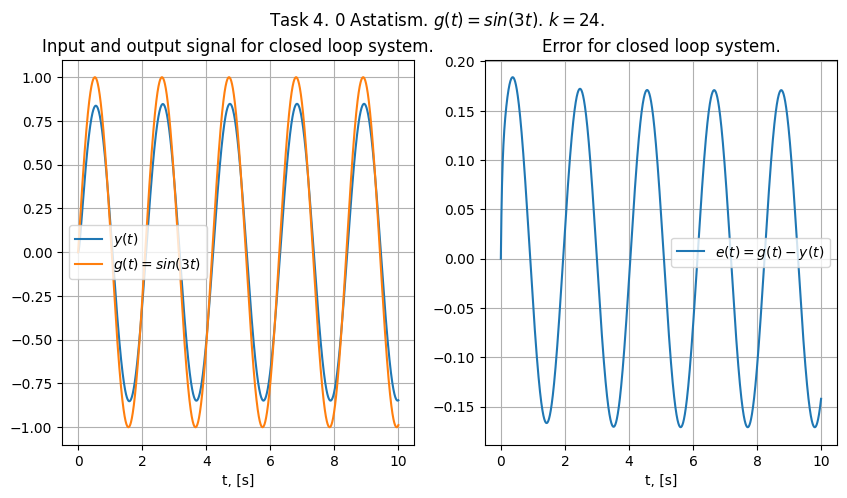

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"Task 4. 0 Astatism. $g(t)=sin(3t)$. $k={k_val}$.")
ax[0].plot(time_4,ctrl.forced_response(tf_4,time_4,np.sin(3*time_4)).outputs,label="$y(t)$")
ax[0].plot(time_4, np.sin(3*time_4),label="$g(t)=sin(3t)$")
ax[0].set_xlabel("t, [s]")
ax[0].grid(True)
ax[0].set_title(f"Input and output signal for closed loop system.")
ax[0].legend()

ax[1].plot(time_4,np.sin(3*time_4)-ctrl.forced_response(tf_4,time_4,np.sin(3*time_4)).outputs,label="$e(t)=g(t)-y(t)$")
ax[1].set_xlabel("t, [s]")
ax[1].grid(True)
ax[1].set_title(f"Error for closed loop system.")
ax[1].legend()

## Task 5 (1 astatism)

In [122]:
time_5 = time_4.copy()

In [123]:
W_reg_5 = k_0 + k_1/s

In [124]:
W_f = W_4 * W_reg_5/(1+ W_reg_5*W_4)
W_f.simplify()

(s + 1)*(k_0*s + k_1)/(s*(s**2 + 5*s + 6) + (s + 1)*(k_0*s + k_1))

In [125]:
num, den = sympy.fraction(W_f.simplify())
den.expand(),"====", num.expand()

(k_0*s**2 + k_0*s + k_1*s + k_1 + s**3 + 5*s**2 + 6*s,
 '====',
 k_0*s**2 + k_0*s + k_1*s + k_1)

In [142]:
k_0_val = 8
k_1_val = 15

In [143]:
num_k = list(map(float, sympy.Poly((num.expand()).subs(k_0,k_0_val).subs(k_1,k_1_val),s).all_coeffs()))
denom_k = list(map(float, sympy.Poly((den.expand()).subs(k_0,k_0_val).subs(k_1,k_1_val),s).all_coeffs()))

In [144]:
tf_5 = ctrl.tf(num_k,denom_k)
tf_5

TransferFunction(array([ 8., 23., 15.]), array([ 1., 13., 29., 15.]))

0.0002470256257407488


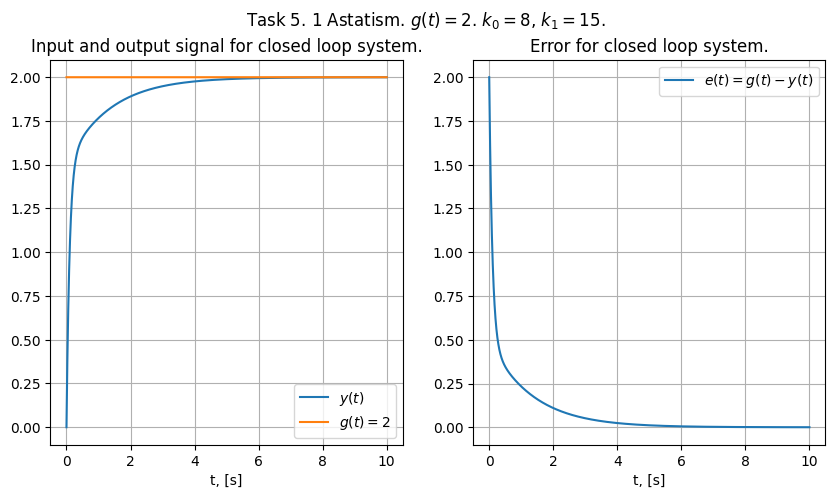

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"Task 5. 1 Astatism. $g(t)=2$. $k_0={k_0_val}$, $k_1={k_1_val}$.")
ax[0].plot(time_5,ctrl.forced_response(tf_5,time_5,2).outputs,label="$y(t)$")
ax[0].plot(time_5, np.ones_like(time_5)*2,label="$g(t)=2$")
ax[0].set_xlabel("t, [s]")
ax[0].grid(True)
ax[0].set_title(f"Input and output signal for closed loop system.")
ax[0].legend()

ax[1].plot(time_5, np.ones_like(time_5)*2-ctrl.forced_response(tf_5,time_5,2).outputs,label="$e(t)=g(t)-y(t)$")
ax[1].set_xlabel("t, [s]")
ax[1].grid(True)
ax[1].set_title(f"Error for closed loop system.")
ax[1].legend()
print(2-ctrl.forced_response(tf_5,time_5,2).outputs[-1])

0.39983806377315645


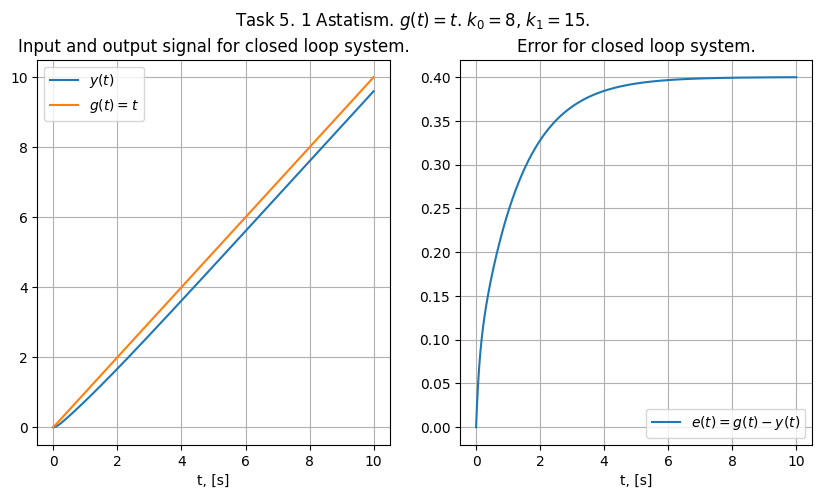

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"Task 5. 1 Astatism. $g(t)=t$. $k_0={k_0_val}$, $k_1={k_1_val}$.")
ax[0].plot(time_5,ctrl.forced_response(tf_5,time_5,time_5).outputs,label="$y(t)$")
ax[0].plot(time_5, time_5,label="$g(t)=t$")
ax[0].set_xlabel("t, [s]")
ax[0].grid(True)
ax[0].set_title(f"Input and output signal for closed loop system.")
ax[0].legend()

ax[1].plot(time_5, time_5-ctrl.forced_response(tf_5,time_5,time_5).outputs,label="$e(t)=g(t)-y(t)$")
ax[1].set_xlabel("t, [s]")
ax[1].grid(True)
ax[1].set_title(f"Error for closed loop system.")
ax[1].legend()
print(10-ctrl.forced_response(tf_5,time_5,time_5).outputs[-1])
# plt.plot(time_5,ctrl.forced_response(tf_5,time_5,time_5).outputs)
# plt.plot(time_5, time_5)

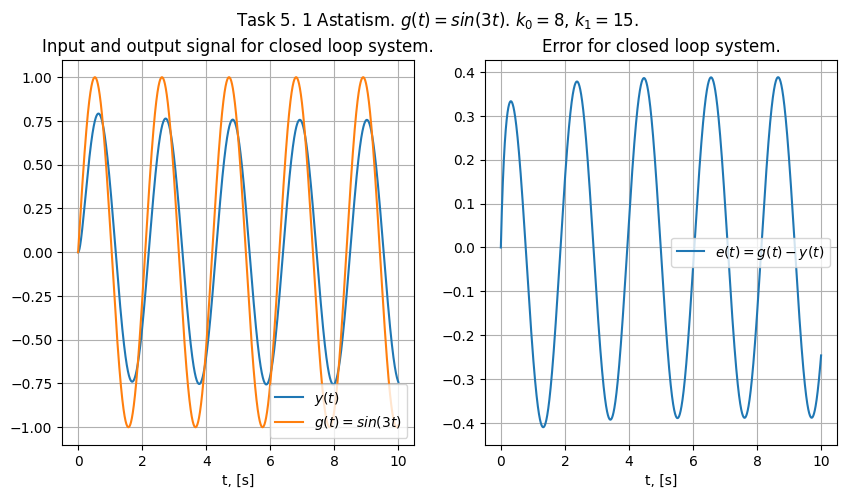

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"Task 5. 1 Astatism. $g(t)=sin(3t)$. $k_0={k_0_val}$, $k_1={k_1_val}$.")
ax[0].plot(time_5,ctrl.forced_response(tf_5,time_5,np.sin(3*time_5)).outputs,label="$y(t)$")
ax[0].plot(time_5, np.sin(3*time_5),label="$g(t)=sin(3t)$")
ax[0].set_xlabel("t, [s]")
ax[0].grid(True)
ax[0].set_title(f"Input and output signal for closed loop system.")
ax[0].legend()

ax[1].plot(time_5, np.sin(3*time_5)-ctrl.forced_response(tf_5,time_5,np.sin(3*time_5)).outputs,label="$e(t)=g(t)-y(t)$")
ax[1].set_xlabel("t, [s]")
ax[1].grid(True)
ax[1].set_title(f"Error for closed loop system.")
ax[1].legend()
# plt.plot(time_5,ctrl.forced_response(tf_5,time_5,np.sin(3*time_5)).outputs)
# plt.plot(time_5, np.sin(3*time_5))

## Task 6 (extended regulator)

In [149]:
W_sys_6 = 1/s**2
W_sys_6

s**(-2)

In [150]:
sigma_1, sigma_2, r = sympy.symbols("sigma_1 sigma_2 r")

In [151]:
W_reg_num_6 = s**2 * ( \
    s**3 * (85 - sigma_1**2 - sigma_2**2) + \
    s**2 * (225 - r * (sigma_1**2 + sigma_2**2)) + \
    s * (274 - sigma_1**2 * sigma_2**2) + \
    120 - r * sigma_1**2 * sigma_2**2)

W_reg_denom_6 = (s**2 + sigma_1**2)*(s**2 + sigma_2**2)*(s+r)

W_reg_6 =W_reg_num_6/W_reg_denom_6
W_reg_6

s**2*(-r*sigma_1**2*sigma_2**2 + s**3*(-sigma_1**2 - sigma_2**2 + 85) + s**2*(-r*(sigma_1**2 + sigma_2**2) + 225) + s*(-sigma_1**2*sigma_2**2 + 274) + 120)/((r + s)*(s**2 + sigma_1**2)*(s**2 + sigma_2**2))

In [152]:
W_full_6 = W_reg_6 * W_sys_6 / (1 + W_reg_6 * W_sys_6)
W_full_6.simplify()

(-r*s**2*sigma_1**2 - r*s**2*sigma_2**2 - r*sigma_1**2*sigma_2**2 - s**3*sigma_1**2 - s**3*sigma_2**2 + 85*s**3 + 225*s**2 - s*sigma_1**2*sigma_2**2 + 274*s + 120)/(r*s**4 + s**5 + 85*s**3 + 225*s**2 + 274*s + 120)

In [153]:
omega_1, omega_2 = 1., 2.

In [154]:
num, den = sympy.fraction(W_full_6.simplify())
num_k = list(map(float, sympy.Poly((num.expand()).subs(r,15.).subs(sigma_1,omega_1+omega_2).subs(sigma_2,omega_1-omega_2),s).all_coeffs()))
denom_k = list(map(float, sympy.Poly((den.expand()).subs(r,15.),s).all_coeffs()))

In [155]:
tf_6 = ctrl.tf(num_k,denom_k)

In [156]:
time_6 = time_5.copy()

Text(0.5, 1.0, 'Error for closed loop system.')

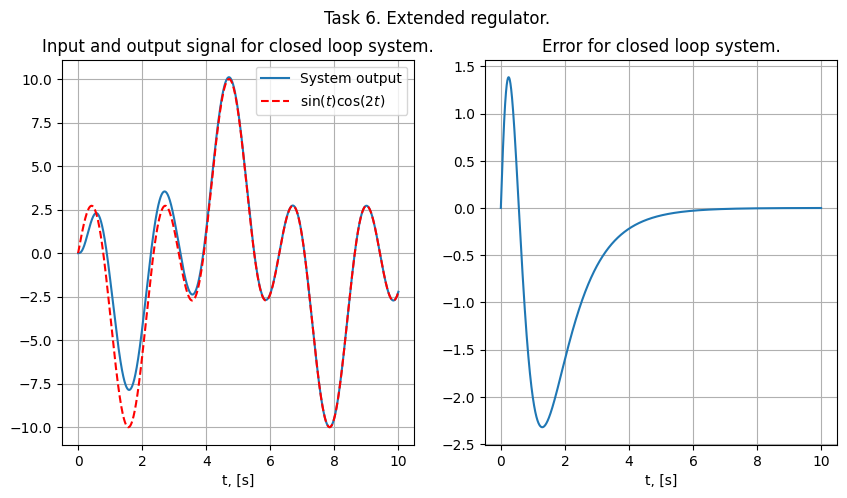

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Task 6. Extended regulator.")
ax[0].plot(time_6,ctrl.forced_response(tf_6,time_6,10*np.sin(time_6)*np.cos(2*time_6)).outputs,label="System output")
ax[0].plot(time_6, 10*np.sin(time_6)*np.cos(2*time_6),"r--",label="$\sin(t) \cos(2t)$")
ax[0].set_xlabel("t, [s]")
ax[0].grid(True)
ax[0].set_title(f"Input and output signal for closed loop system.")
ax[0].legend()

ax[1].plot(time_6,10*np.sin(time_6)*np.cos(2*time_6) - ctrl.forced_response(tf_6,time_6,10*np.sin(time_6)*np.cos(2*time_6)).outputs)
ax[1].set_xlabel("t, [s]")
ax[1].grid(True)
ax[1].set_title(f"Error for closed loop system.")

## Task 7 (Nonlinear system)

In [138]:
def pendulum_update(t, x, u, params):
    g = params.get('g', 9.8)
    l = params.get('l', 0.5)
    # print(x)
    theta_2 = u + g/l*np.sin(x[1])
    theta_1 = x[0] + theta_2 * dt
    
    return np.array([
        theta_2,
        theta_1,
        ])

def pendulum_output(t, x, u, params):
    return x

pendulum_params={'g': 9.8, 'l':0.5}
pendulum = ctrl.NonlinearIOSystem(
    pendulum_update, pendulum_output, states=2, name='pendulum',
    inputs=['momentum'], outputs=['theta1','theta'], params=pendulum_params)

time_7 = time_6.copy()

time, outputs = ctrl.input_output_response(pendulum, time_7, 0, [0,0.5])

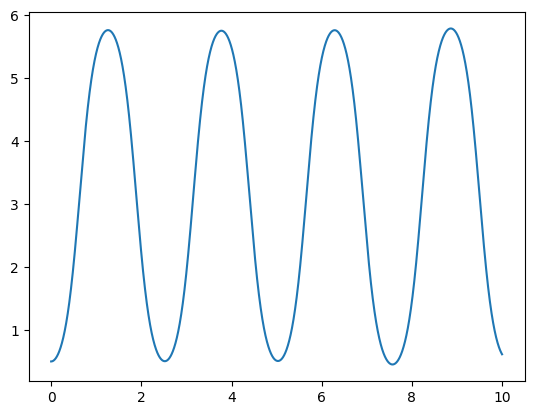

In [139]:
plt.plot(time_7,outputs[1,:])

In [141]:
om_1, g_, l_ = sympy.symbols("\omega_1 g l")

In [143]:
W_reg_num_6 = s**3 * (85 - om_1**2 +g_/l_) + \
    s**2 * (225 - r*om_1**2 + r * g_/l_) + \
    s * (274 + g_/l_*om_1**2) + \
    120 + g_/l_ * om_1**2 * r

W_reg_denom_6 = (s**2 + om_1**2)*(s+r)

W_reg_7 =W_reg_num_6/W_reg_denom_6
W_reg_7.simplify()

(\omega_1**2*g*r + 120*l + s**3*(g + l*(85 - \omega_1**2)) + s**2*(g*r + l*(-\omega_1**2*r + 225)) + s*(\omega_1**2*g + 274*l))/(l*(\omega_1**2 + s**2)*(r + s))

In [145]:
num, den = sympy.fraction(W_reg_7.simplify())
num_k = list(map(float, sympy.Poly((num.expand()).subs(r,15.).subs(om_1,1).subs(g_,9.8).subs(l_,0.5),s).all_coeffs()))
denom_k = list(map(float, sympy.Poly((den.expand()).subs(r,15.).subs(om_1,1).subs(l_,0.5),s).all_coeffs()))

In [146]:
tf_reg_7 = ctrl.tf(num_k,denom_k)
tf_reg_7

TransferFunction(array([ 51.8, 252. , 146.8, 207. ]), array([0.5, 7.5, 0.5, 7.5]))

In [156]:
X_init_7 = [0,0,0]
def control_output(t, x, z, params):
    global X_init_7
    y = ctrl.forced_response(tf_reg_7,[t,t+dt],z[0]-z[1],X_init_7)
    X_init_7 = y.states[:,-1]
    return y.outputs[-1]

control = ctrl.NonlinearIOSystem(
    None, control_output, name='control',
    inputs=['momentumd','theta'],
    outputs=['momentum'])

In [157]:
vehicle_closed = ctrl.interconnect(
    (pendulum, control),
    inputs=['momentumd'],
    outputs=['theta']
)

/home/vladislav/.pyenv/versions/3.10.11/envs/control/lib/python3.10/site-packages/control/iosys.py:1521: UserWarning: Unused output(s) in InterconnectedSystem: (0, 0) : pendulum.theta1
  warn(msg)


In [158]:
U_7 = 0.1 * np.sin(time_7)

resp = ctrl.input_output_response(
    vehicle_closed, time_7, U_7, 0)
time, outputs = resp.time, resp.outputs

/home/vladislav/.pyenv/versions/3.10.11/envs/control/lib/python3.10/site-packages/control/timeresp.py:946: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


RuntimeError: Algebraic loop detected.